# Evaluation du Modele Ambisonic Upscaler (FOA -> HOA2)

Ce notebook presente une analyse quantitative et qualitative du modele d'upscaling ambisonique. Il inclut des comparaisons detaillees entre les fichiers de reference (ground truth) et les predictions du reseau de neurones.

### Methodologie :
- **Source** : Checkpoint 'best_robust.pt'.
- **Echantillonnage** : Analyse de segments de 5 secondes extraits au centre de chaque fichier.
- **Alignement** : Correction automatique des inversions de phase pour assurer une comparaison valide des metriques.
- **Metriques** : SNR (Signal-to-Noise Ratio), SI-SDR, Correlation de Pearson et LSD (Log-Spectral Distance).

In [47]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchaudio
import numpy as np
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots
from pathlib import Path
import soundfile as sf
import pandas as pd
from scipy import signal
from IPython.display import display, Audio
import warnings
warnings.filterwarnings('ignore')

DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'mps' if torch.backends.mps.is_available() else 'cpu')
print(f"Device : {DEVICE}")

MODEL_PATH = Path("../Checkpoints/final/best_robust.pt")
SAMPLES_DIR = Path("test_samples")

CONFIG = {
    "foa_channels": 4,
    "hoa2_channels": 9,
    "sample_rate": 48000,
    "encoder_dim": 512,
    "hidden_dim": 128,
    "kernel_size": 3,
    "num_layers": 7,
    "num_repeats": 2,
}

CHANNEL_NAMES = ['W', 'Y', 'Z', 'X', 'V', 'T', 'R', 'S', 'U']
CHANNEL_DESCR = ['Omni', 'Y (L/R)', 'Z (U/D)', 'X (F/B)', 'Diag XY', 'Diag YZ', 'Quad Z', 'Diag XZ', 'Quad XY']

Device : mps


## 1. Chargement du Modele

In [48]:
class GlobalLayerNorm(nn.Module):
    def __init__(self, dim, eps=1e-5):
        super().__init__()
        self.gamma = nn.Parameter(torch.ones(dim))
        self.beta = nn.Parameter(torch.zeros(dim))
        self.eps = eps

    def forward(self, x):
        mean = x.mean(dim=(1, 2), keepdim=True)
        var = x.var(dim=(1, 2), keepdim=True, unbiased=False)
        return (x - mean) / torch.sqrt(var + self.eps) * self.gamma.view(1, -1, 1) + self.beta.view(1, -1, 1)

class CausalConv1d(nn.Module):
    def __init__(self, in_ch, out_ch, kernel, dilation=1):
        super().__init__()
        self.pad = (kernel - 1) * dilation
        self.conv = nn.Conv1d(in_ch, out_ch, kernel, padding=self.pad, dilation=dilation)

    def forward(self, x):
        x = self.conv(x)
        return x[:, :, :-self.pad] if self.pad > 0 else x

class CausalConvBlock(nn.Module):
    def __init__(self, hidden_dim, kernel_size, dilation):
        super().__init__()
        self.conv1 = CausalConv1d(hidden_dim, hidden_dim, kernel_size, dilation)
        self.conv2 = nn.Conv1d(hidden_dim, hidden_dim, 1)
        self.norm1 = GlobalLayerNorm(hidden_dim)
        self.norm2 = GlobalLayerNorm(hidden_dim)
        self.prelu = nn.PReLU()

    def forward(self, x):
        residual = x
        h = self.prelu(self.norm1(self.conv1(x)))
        return residual + self.norm2(self.conv2(h))

class AmbiUpscalerHOA2(nn.Module):
    def __init__(self, config):
        super().__init__()
        d = config["encoder_dim"]
        k = config["kernel_size"]
        self.encoder = nn.Sequential(
            nn.Conv1d(4, d, 1),
            nn.PReLU(),
            GlobalLayerNorm(d)
        )
        self.blocks = nn.ModuleList([
            CausalConvBlock(d, k, 2**(i % config["num_layers"]))
            for i in range(config["num_layers"] * config["num_repeats"])
        ])
        self.decoder = nn.Sequential(
            nn.Conv1d(d, d, 1),
            nn.PReLU(),
            GlobalLayerNorm(d),
            nn.Conv1d(d, 9, 1)
        )

    def forward(self, x):
        h = self.encoder(x)
        for block in self.blocks:
            h = block(h)
        return self.decoder(h)

model = AmbiUpscalerHOA2(CONFIG).to(DEVICE)
checkpoint = torch.load(MODEL_PATH, map_location=DEVICE, weights_only=False)
if isinstance(checkpoint, dict) and 'model_state_dict' in checkpoint:
    model.load_state_dict(checkpoint['model_state_dict'])
else:
    model.load_state_dict(checkpoint)
model.eval()
print("Modele charge avec succes.")

Modele charge avec succes.


## 2. Metriques et Utilitaires

In [49]:
def log_spectral_distance(ref, est, sr=48000):
    # Calcul du spectrogramme
    f, t, S_ref = signal.stft(ref, fs=sr, nperseg=1024)
    f, t, S_est = signal.stft(est, fs=sr, nperseg=1024)
    
    # Power spectral density
    psd_ref = np.abs(S_ref)**2
    psd_est = np.abs(S_est)**2
    
    # Log-distance (eviter log(0))
    log_dist = (np.log10(psd_ref + 1e-12) - np.log10(psd_est + 1e-12))**2
    lsd = np.mean(np.sqrt(np.mean(log_dist, axis=0)))
    return lsd

def get_metrics(ref, est):
    snr = 10 * np.log10(np.sum(ref**2) / (np.sum((ref - est)**2) + 1e-10))
    corr = np.corrcoef(ref, est)[0, 1] if np.std(ref) > 1e-6 else 0
    si_sdr = 10 * np.log10(np.dot(ref, est)**2 / (np.sum(ref**2) * np.sum(est**2) - np.dot(ref, est)**2 + 1e-10))
    lsd = log_spectral_distance(ref, est)
    return snr, corr, si_sdr, lsd

## 3. Resultats Quantitatifs

In [50]:
all_files = list(SAMPLES_DIR.glob("*.wav"))
detailed_results = []

for f in all_files:
    if sf.info(f).channels < 9: continue
    foa, target, pred = process_audio(f)
    
    file_data = {'File': f.name}
    for i in range(9):
        snr, corr, sisdr, lsd = get_metrics(target[i], pred[i])
        file_data[f'{CHANNEL_NAMES[i]}_SNR'] = snr
        file_data[f'{CHANNEL_NAMES[i]}_Corr'] = corr
        file_data[f'{CHANNEL_NAMES[i]}_LSD'] = lsd
    
    # Moyenne HOA2 (Canaux 4-8)
    hoa2_metrics = [get_metrics(target[i], pred[i]) for i in range(4, 9)]
    file_data['HOA2_Mean_SNR'] = np.mean([m[0] for m in hoa2_metrics])
    file_data['HOA2_Mean_Corr'] = np.mean([m[1] for m in hoa2_metrics])
    file_data['HOA2_Mean_LSD'] = np.mean([m[3] for m in hoa2_metrics])
    
    detailed_results.append(file_data)

df = pd.DataFrame(detailed_results)
display(df[['File', 'HOA2_Mean_SNR', 'HOA2_Mean_Corr', 'HOA2_Mean_LSD']])

,File,HOA2_Mean_SNR,HOA2_Mean_Corr,HOA2_Mean_LSD
0,tm_o4_25ch.wav,-7.883763,-0.100629,1.166397
1,deus-ex-machina_4o.wav,-3.793339,0.040224,0.807174
2,Streichquartett_4o.wav,-5.309048,-0.123883,0.816361
3,ort3org_o3.wav,-17.583119,0.014909,0.793669
4,hoast_demo_o4_25ch.wav,-6.593166,0.069415,0.963516
5,elliots_joy_o2_9ch.wav,-23.167654,-0.011588,1.231280
6,space_walker_o3.wav,-17.733667,-0.182054,1.324336


### Analyse par Canal - Tableau Detaille

In [53]:
def print_channel_report(file_idx=0):
    f = all_files[file_idx]
    foa, target, pred = process_audio(f)
    print(f"Analyse detaillee pour : {f.name}\n")
    
    data = []
    for i in range(9):
        snr, corr, sisdr, lsd = get_metrics(target[i], pred[i])
        data.append({
            'Canal': CHANNEL_NAMES[i],
            'Description': CHANNEL_DESCR[i],
            'SNR (dB)': f"{snr:.2f}",
            'Correlation': f"{corr:.4f}",
            'SI-SDR (dB)': f"{sisdr:.2f}",
            'LSD': f"{lsd:.3f}"
        })
    
    display(pd.DataFrame(data))

if all_files: print_channel_report(0)

Analyse detaillee pour : tm_o4_25ch.wav



,Canal,Description,SNR (dB),Correlation,SI-SDR (dB),LSD
0,W,Omni,14.06,0.9935,13.90,0.063
1,Y,Y (L/R),26.80,0.9992,27.17,0.051
2,Z,Z (U/D),-8.38,0.9865,-8.81,0.560
3,X,X (F/B),17.79,0.9997,17.74,0.051
4,V,Diag XY,-2.85,-0.6978,-0.23,0.674
5,T,Diag YZ,-24.74,-0.0096,-44.12,2.340
6,R,Quad Z,-1.30,0.0887,-28.00,0.712
7,S,Diag XZ,-8.32,0.0160,-36.32,1.344
8,U,Quad XY,-2.22,0.0996,-20.04,0.762


## 4. Visualisations de Comparaison

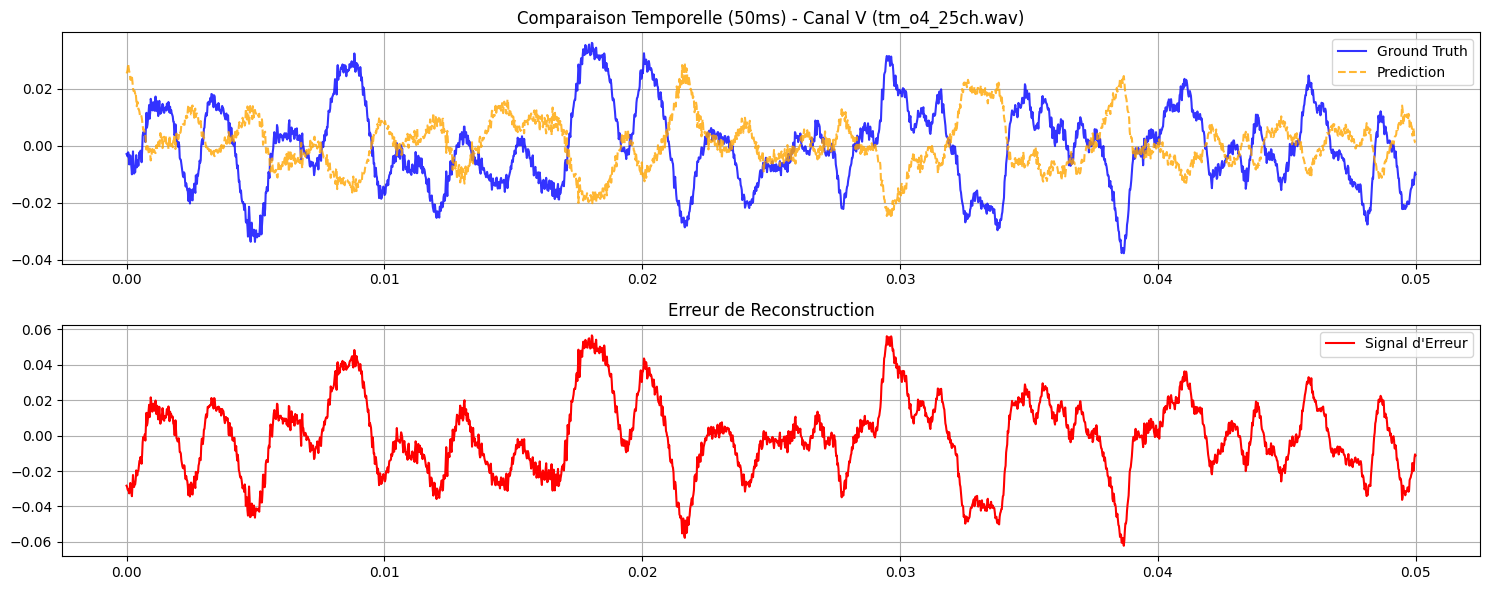

In [54]:
def plot_comparison(file_idx=0, channel_idx=4):
    foa, target, pred = process_audio(all_files[file_idx])
    t = np.linspace(0, 0.05, int(0.05 * 48000)) # 50ms
    
    plt.figure(figsize=(15, 6))
    plt.subplot(2, 1, 1)
    plt.plot(t, target[channel_idx, :len(t)], label='Ground Truth', alpha=0.8, color='blue')
    plt.plot(t, pred[channel_idx, :len(t)], label='Prediction', alpha=0.8, color='orange', linestyle='--')
    plt.title(f"Comparaison Temporelle (50ms) - Canal {CHANNEL_NAMES[channel_idx]} ({all_files[file_idx].name})")
    plt.legend()
    plt.grid(True)
    
    plt.subplot(2, 1, 2)
    error = target[channel_idx] - pred[channel_idx]
    plt.plot(t, error[:len(t)], label='Signal d\'Erreur', color='red')
    plt.title("Erreur de Reconstruction")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

if all_files: plot_comparison(0, 4)

## 5. Matrice de Correlation Globale
Visualisation des inter-correlations entre canaux predits et reels.

In [55]:
if all_files:
    foa, target, pred = process_audio(all_files[0])
    corr_matrix = np.zeros((9, 9))
    for i in range(9):
        for j in range(9):
            corr_matrix[i, j] = np.corrcoef(pred[i], target[j])[0, 1]
            
    fig = px.imshow(corr_matrix, 
                    x=CHANNEL_NAMES, y=CHANNEL_NAMES,
                    labels=dict(x="Target", y="Prediction", color="Correlation"),
                    title="Matrice de Correlation (Alignee)",
                    color_continuous_scale='RdBu_r')
    fig.update_layout(template='plotly_dark')
    fig.show()

## 6. Analyse Spatiale 3D

In [56]:
def spherical_harmonics_2nd_order(theta, phi):
    Y = np.zeros((len(theta), 9))
    Y[:, 0] = 1.0 # W
    Y[:, 1] = np.sin(theta) * np.cos(phi) # Y
    Y[:, 2] = np.sin(phi) # Z
    Y[:, 3] = np.cos(theta) * np.cos(phi) # X
    Y[:, 4] = np.sqrt(3/4) * np.sin(2*theta) * np.cos(phi)**2 
    Y[:, 5] = np.sqrt(3/4) * np.sin(theta) * np.sin(2*phi) 
    Y[:, 6] = 0.5 * (3*np.sin(phi)**2 - 1) 
    Y[:, 7] = np.sqrt(3/4) * np.cos(theta) * np.sin(2*phi) 
    Y[:, 8] = np.sqrt(3/4) * np.cos(2*theta) * np.cos(phi)**2 
    return Y

if all_files:
    foa, target, pred = process_audio(all_files[0])
    res = 50
    theta = np.linspace(0, 2*np.pi, res)
    phi = np.linspace(-np.pi/2, np.pi/2, res//2)
    th_grid, ph_grid = np.meshgrid(theta, phi)
    
    Y = spherical_harmonics_2nd_order(th_grid.flatten(), ph_grid.flatten())
    energy_pred = np.abs(np.dot(Y, np.sqrt(np.mean(pred**2, axis=1)))).reshape(th_grid.shape)
    energy_target = np.abs(np.dot(Y, np.sqrt(np.mean(target**2, axis=1)))).reshape(th_grid.shape)
    
    fig = make_subplots(rows=1, cols=2, specs=[[{'type': 'surface'}, {'type': 'surface'}]],
                        subplot_titles=('Prediction HOA2', 'Ground Truth HOA2'))
    
    for i, e in enumerate([energy_pred, energy_target]):
        x = (1 + e) * np.cos(ph_grid) * np.cos(th_grid)
        y = (1 + e) * np.cos(ph_grid) * np.sin(th_grid)
        z = (1 + e) * np.sin(ph_grid)
        fig.add_trace(go.Surface(x=x, y=y, z=z, surfacecolor=e, colorscale='Magma', showscale=False), row=1, col=i+1)
    
    fig.update_layout(title="Comparaison Spatiale 3D", template='plotly_dark', height=600)
    fig.show()